**Datasets:**
`<clean/noisy>-<noise level in mm>-<filter>-<pid/dwa>-<strategy>-<g/r>-<before/after>-<no>.csv`

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from typing import Union
import warnings

warnings.filterwarnings('ignore')

START_FROM = 0 # 100: 2790 500: 6090
NO_ROWS = 8000  # Limit window to be analysed (up to 8000 rows, ~ 2.5 mins)
X_AXES = np.arange(NO_ROWS)

CLEAN = "clean-dwa-pc-r.csv"
NOISY = "noisy-10-dwa-pc-r.csv"
NOISY_KALMAN = "noisy-10-kalman-dwa-pc-r.csv"

X_COL, Y_COL, TH_COL, V_COL = "x", "y", "orientation", "vector"
COLS = [X_COL, Y_COL, TH_COL]


def format_data(filename: str) -> pd.DataFrame:
    data = pd.read_csv(filename)
    return data[COLS].iloc[START_FROM : (START_FROM + NO_ROWS)]


CLEAN_FD = format_data(CLEAN)
NOISY_FD = format_data(NOISY)
NOISY_KALMAN_FD = format_data(NOISY_KALMAN)

In [2]:
def percentage_diff(
    old: float,
    new: float
) -> float:
    return round((new-old) / old * 100, 1)


def diff_squared(t: float, a: float) -> float:
    return (t - a) ** 2


def squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str
) -> pd.DataFrame:        
    return true_data[param].combine(
            other=actual_data[param],
            func=diff_squared
        )


def mean_squared_error(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame,
    param: str
) -> float:
    return squared_error(true_data, actual_data, param).mean()


def vectorify(x: float, y: float) -> np.ndarray:
    return np.array((x, y))


def error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame
) -> pd.DataFrame:    
    true_vec = true_data[X_COL].combine(
        other=true_data[Y_COL],
        func=vectorify
    )
    
    actual_vec = actual_data[X_COL].combine(
        other=actual_data[Y_COL],
        func=vectorify
    )
    
    return true_vec - actual_vec


def norm_error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame
) -> np.ndarray:
    error_vectors = np.vstack(error_vec(true_data, actual_data))
    return np.linalg.norm(error_vectors, axis=1)


def squared_error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame
) -> np.ndarray:
    return norm_error_vec(true_data, actual_data) ** 2


def mean_squared_error_vec(
    true_data: pd.DataFrame,
    actual_data: pd.DataFrame
) -> float:
    return squared_error_vec(true_data, actual_data).mean()

In [3]:
baseline_error_v = norm_error_vec(CLEAN_FD, NOISY_FD) * 100
kalman_error_v = norm_error_vec(CLEAN_FD, NOISY_KALMAN_FD) * 100
reduction_error_v = baseline_error_v - kalman_error_v

fraction_reduced = pd.Series(reduction_error_v).rolling(window=500, min_periods=1).mean()
# zipwith_pct_diff = np.vectorize(percentage_diff)
# pct_red_error_v = zipwith_pct_diff(baseline_error_v, kalman_error_v)

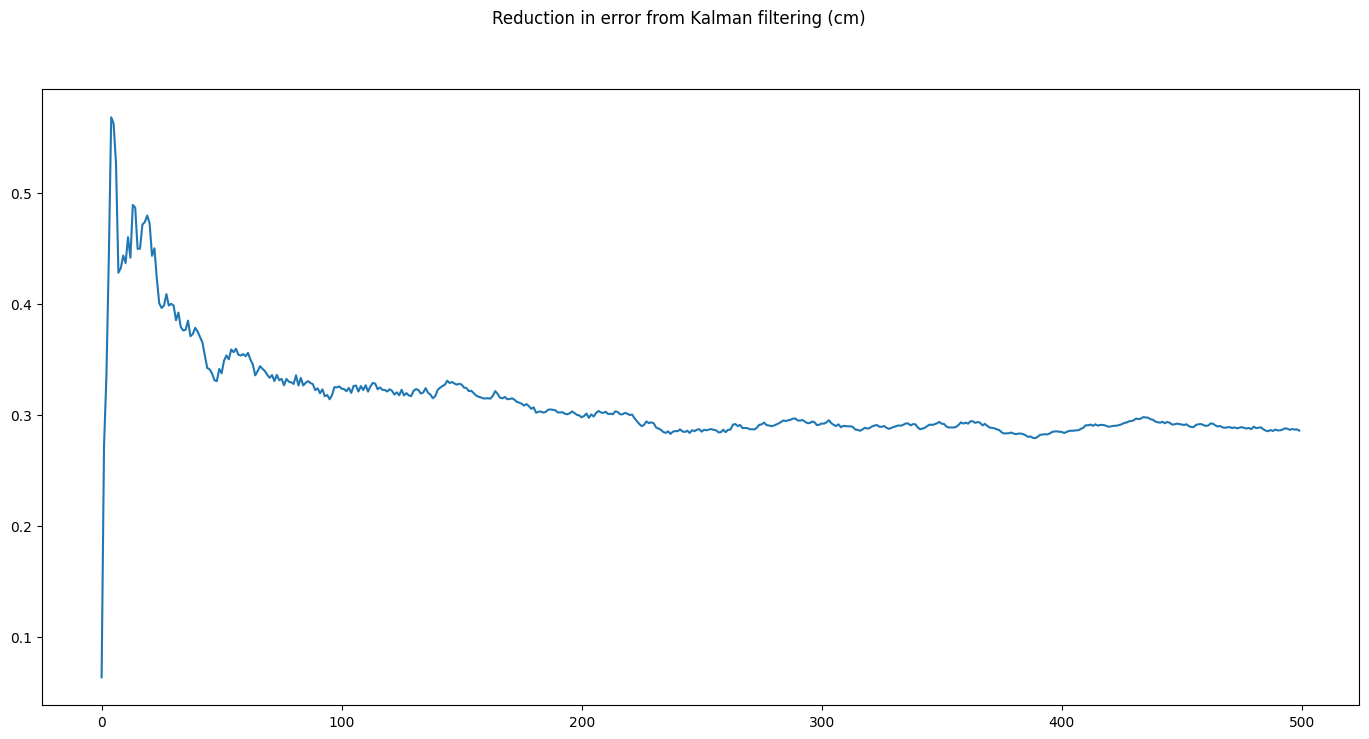

In [201]:
fig, ax = plt.subplots()
fig.set_size_inches(17,8)
fig.suptitle("Reduction in error from Kalman filtering (cm)")

ax.plot(X_AXES, fraction_reduced)

In [202]:
# fig, ax = plt.subplots()
# fig.set_size_inches(17,8)
# fig.suptitle("Error before and after Kalman filtering (cm)")

# baseline_error_v = norm_error_vec(CLEAN_FD, NOISY_FD) * 100
# kalman_error_v = norm_error_vec(CLEAN_FD, NOISY_KALMAN_FD) * 100

# ax.plot(X_AXES, baseline_error_v, "#ffa099")
# ax.plot(X_AXES, kalman_error_v, "g")

Text(0, 0.5, 'Reduction in error (cm)')

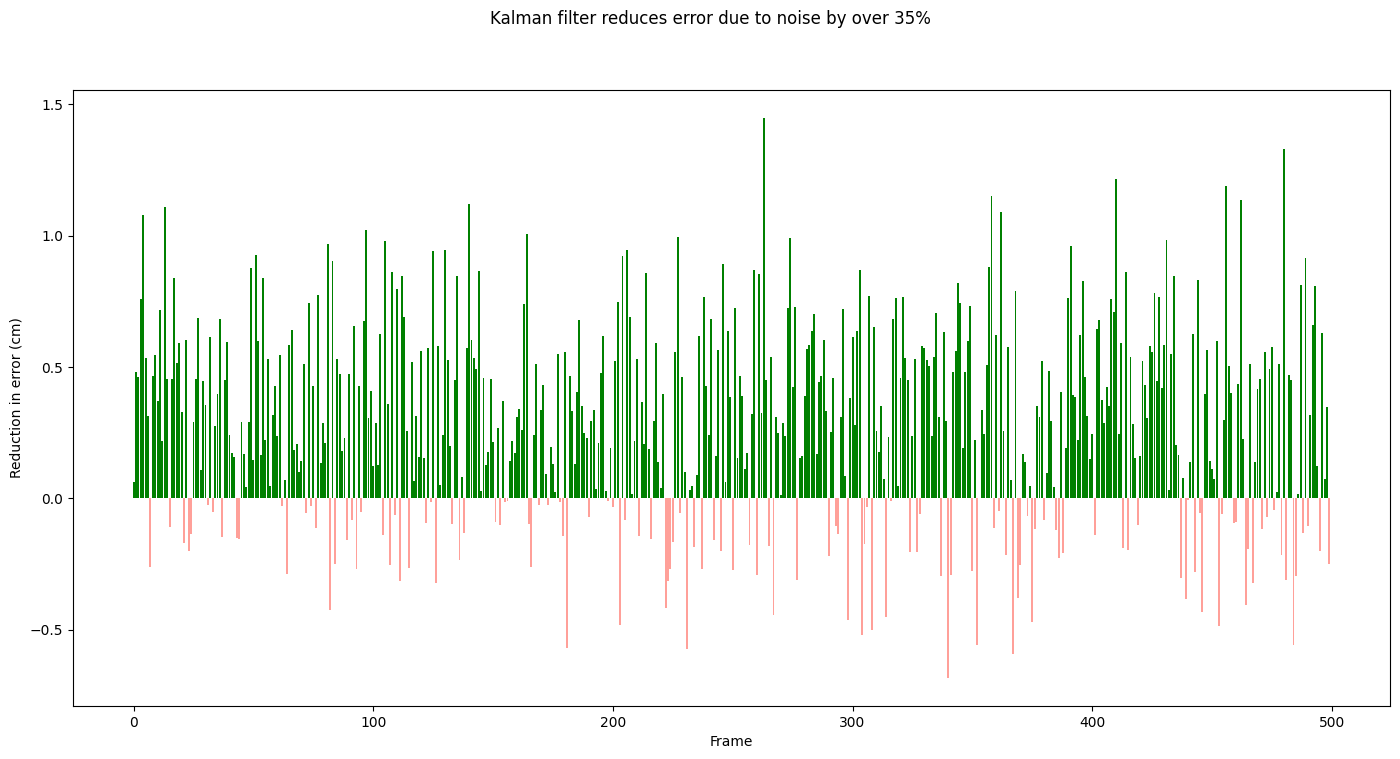

In [203]:
fig, ax = plt.subplots()
fig.set_size_inches(17,8)
fig.suptitle("Kalman filter reduces error due to noise by over 35%")

colours = ['#ffa099' if e < 0 else 'green' for e in reduction_error_v]
bars = ax.bar(X_AXES, reduction_error_v, color=colours)

ax.set_xlabel('Frame')
ax.set_ylabel('Reduction in error (cm)')

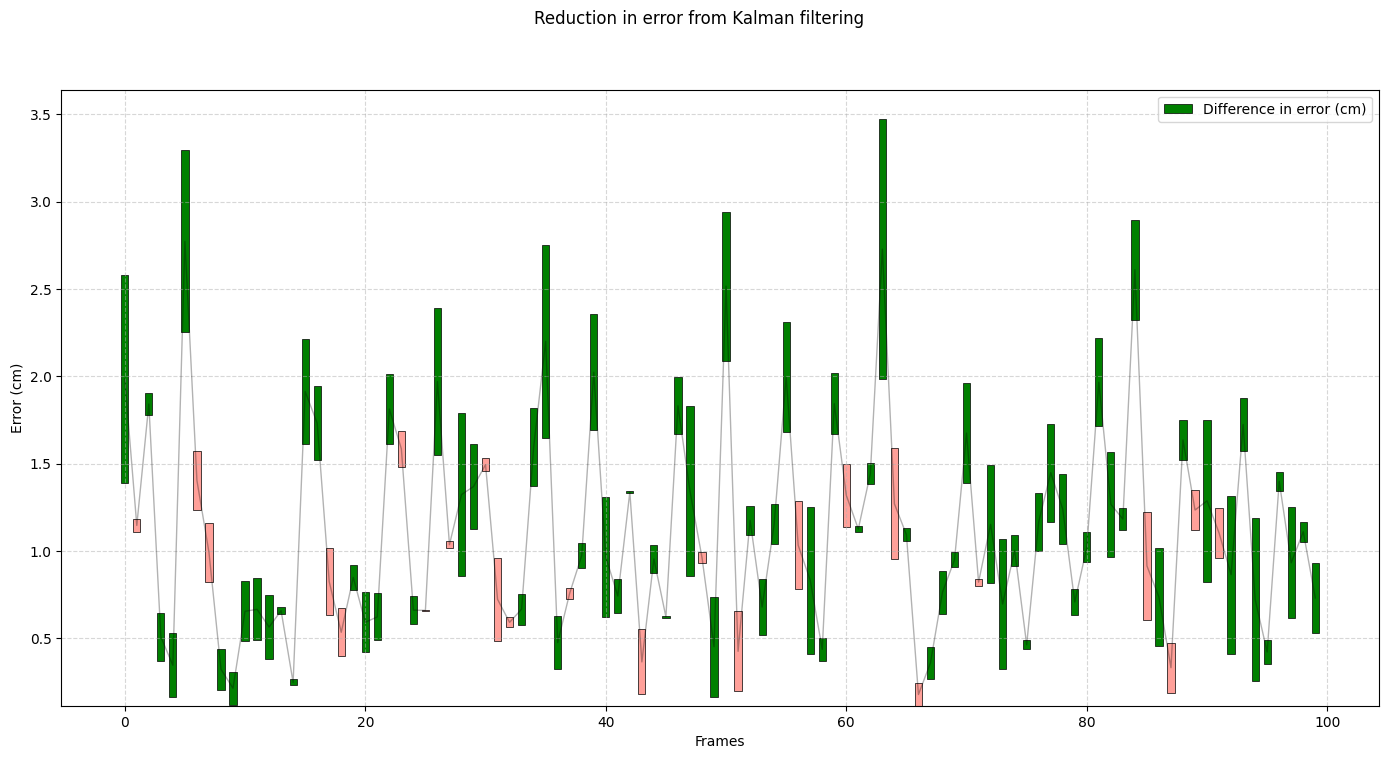

In [157]:
candlesticks = pd.DataFrame({
    'frames': X_AXES,
    'baseline': baseline_error_v,
    'kalman': kalman_error_v
})

candlesticks['ymin'] = candlesticks[['baseline', 'kalman']].min(axis=1)
candlesticks['height'] = (candlesticks['baseline'] - candlesticks['kalman']).abs()
candlesticks['color'] = np.where(candlesticks['baseline'] > candlesticks['kalman'], 'green', '#ffa099')
candlesticks['average'] = candlesticks[['baseline', 'kalman']].mean(axis=1)

fig, ax = plt.subplots()
fig.set_size_inches(17,8)
fig.suptitle("Reduction in error from Kalman filtering")

ax.plot(candlesticks['frames'], candlesticks['average'], color='black', alpha=0.3, linewidth=1)

ax.bar(candlesticks['frames'], candlesticks['height'], bottom=candlesticks['ymin'],
       color=candlesticks['color'], width=0.6, edgecolor='black', linewidth=0.5,
       label='Difference in error (cm)'
)

# Formatting
ax.set_xlabel('Frames')
ax.set_ylabel('Error (cm)')
ax.legend(loc='upper right')
ax.grid(True, linestyle='--', alpha=0.5)

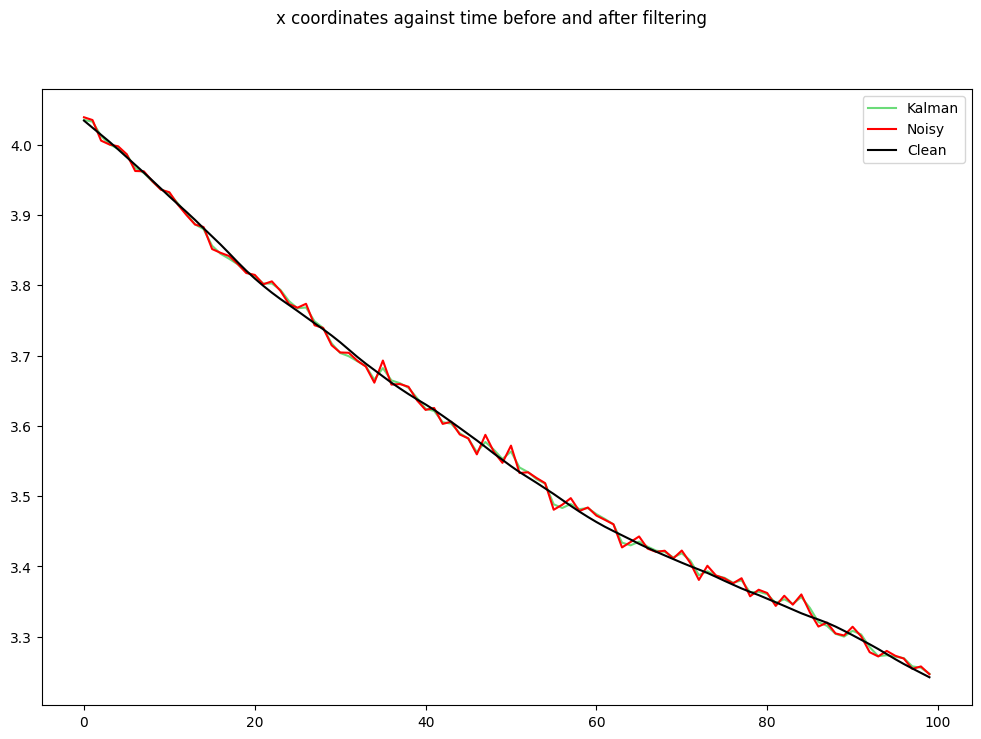

In [153]:
fig, axs = plt.subplots()
fig.set_size_inches(12,8)
fig.suptitle("x coordinates against time before and after filtering")

axs.plot(X_AXES, NOISY_KALMAN_FD[X_COL], "#6bdb79")
axs.plot(X_AXES, NOISY_FD[X_COL], "r")
axs.plot(X_AXES, CLEAN_FD[X_COL], "k")

axs.legend(("Kalman", "Noisy", "Clean"))

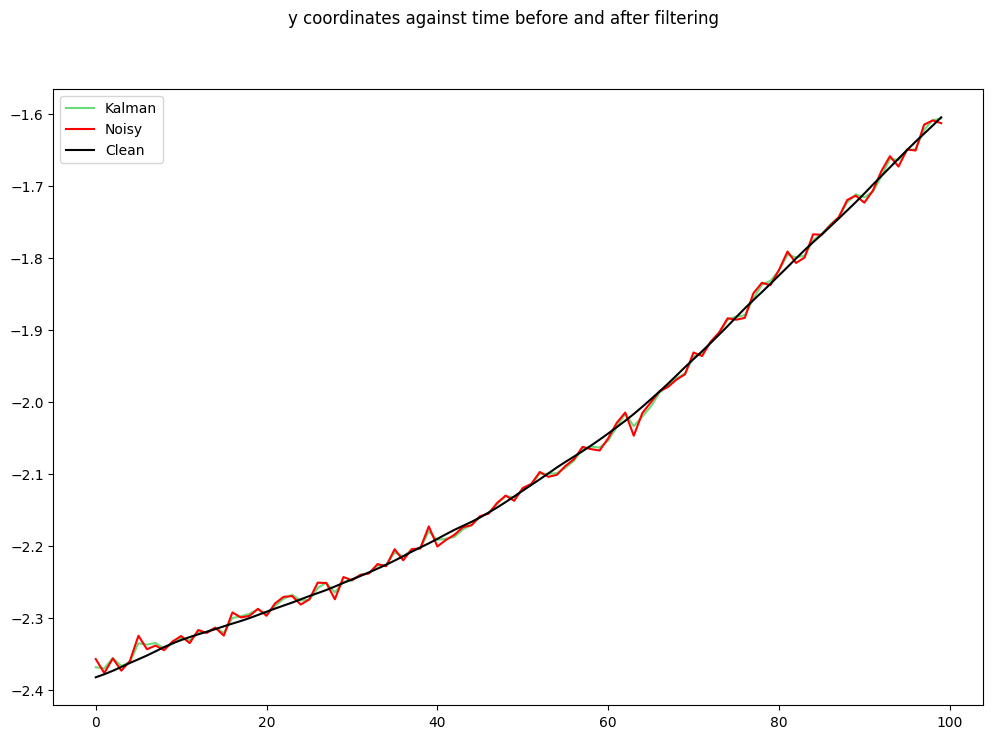

In [154]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
fig.suptitle("y coordinates against time before and after filtering")

ax.plot(X_AXES, NOISY_KALMAN_FD[Y_COL], "#6bdb79")
ax.plot(X_AXES, NOISY_FD[Y_COL], "r")
ax.plot(X_AXES, CLEAN_FD[Y_COL], "k")

ax.legend(("Kalman", "Noisy", "Clean"))

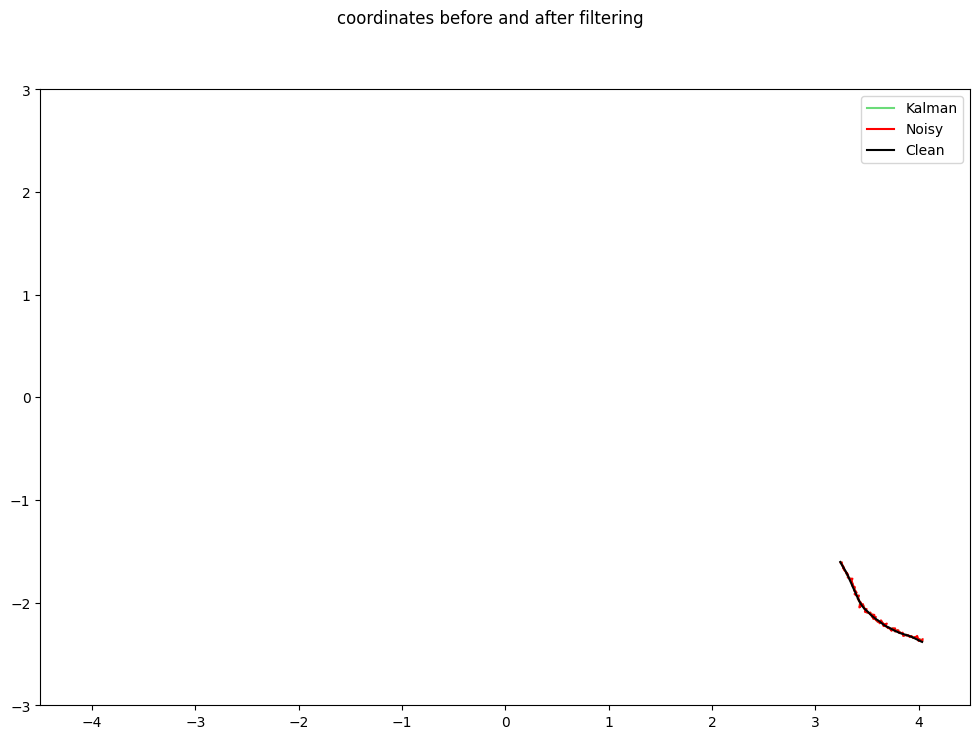

In [155]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
fig.suptitle("coordinates before and after filtering")

ax.set_xlim(-4.5, 4.5)
ax.set_ylim(-3, 3)

ax.plot(NOISY_KALMAN_FD[X_COL], NOISY_KALMAN_FD[Y_COL], "#6bdb79")
ax.plot(NOISY_FD[X_COL], NOISY_FD[Y_COL], "r")
ax.plot(CLEAN_FD[X_COL], CLEAN_FD[Y_COL], "k")

ax.legend(("Kalman", "Noisy", "Clean"))

[Text(0, 0, '-34.2'), Text(0, 0, '-43.8'), Text(0, 0, '-39.1')]

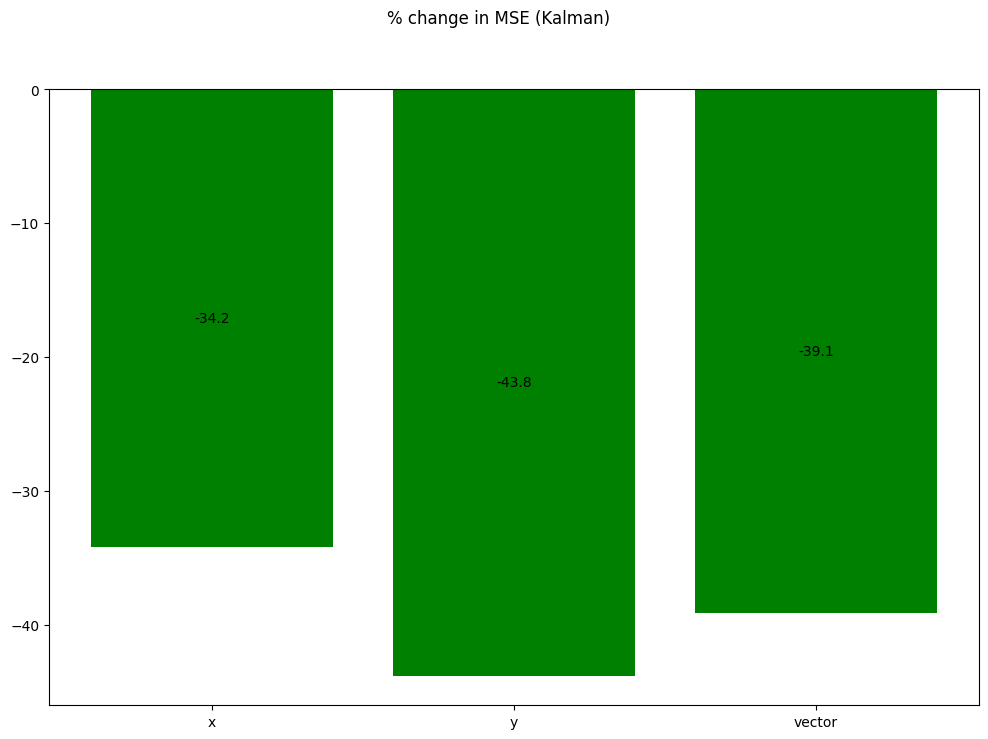

In [156]:
fig, ax = plt.subplots()
fig.set_size_inches(12,8)
fig.suptitle("% change in MSE (Kalman)")

baseline_x = mean_squared_error(CLEAN_FD, NOISY_FD, X_COL)
baseline_y = mean_squared_error(CLEAN_FD, NOISY_FD, Y_COL)
baseline_v = mean_squared_error_vec(CLEAN_FD, NOISY_FD)

error_x = mean_squared_error(CLEAN_FD, NOISY_KALMAN_FD, X_COL)
error_y = mean_squared_error(CLEAN_FD, NOISY_KALMAN_FD, Y_COL)
error_v = mean_squared_error_vec(CLEAN_FD, NOISY_KALMAN_FD)

delta_x = percentage_diff(baseline_x, error_x)
delta_y = percentage_diff(baseline_y, error_y)
delta_v = percentage_diff(baseline_v, error_v)

deltas = [delta_x, delta_y, delta_v]
colours = ['#ffa099' if d > 0 else 'green' for d in deltas]
bars = ax.bar([X_COL, Y_COL, V_COL], deltas, color=colours)
ax.bar_label(bars, label_type='center')